In [7]:
#Import packages
import sys
import math
import numpy as np
import paths
import pickle
sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils
import matplotlib.pyplot as plt

In [5]:
#Check paths to the data are correct
import importlib 
importlib.reload(paths)

<module 'paths' from 'C:\\Users\\Student\\Documents\\OTP\\paths.py'>

In [6]:
#Load the data and define the latitudes of interest
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

Defining the latitude of interest in the first line of code, pick the latitude, where:

0 = 26
1 = -30
2 = -55 
3 = -60 

In [331]:
lat = lats[3]                                                                                                 # 3 is picking latitude -60
lat_str = strf_utils.format_lat_lon(lat)

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))             # This takes a slice needed for the latitude data
inputs

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 312, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 4B -59.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time       (time) datetime64[ns] 2kB 1992-01-16T18:00:00 ... 2017-12-16T0...
Data variables:
    SSH        (time, latitude, longitude) float32 899kB ...
    ZWS        (time, latitude, longitude) float32 899kB ...
    OBP        (time, latitude, longitude) float32 899kB ...
    SSS        (time, latitude, longitude) float32 899kB ...
    SST        (time, latitude, longitude) float32 899kB ...

In [332]:
outputs_fp = f"{data_home}/ecco_data_minimal/{lat_str}_moc_density.pickle"                             # Density pickle to ensure working in density space

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)

outputs = np.expand_dims(outputs, 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (["time", "longitude"], outputs)}, 
                     coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})                   # Replace -60 with the latitude of interest
outputs

<xarray.Dataset> Size: 5kB
Dimensions:   (time: 312, longitude: 1, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 2kB 1992-01-16T18:00:00 ... 2017-12-16T06...
  * latitude  (latitude) int32 4B -60
Dimensions without coordinates: longitude
Data variables:
    moc       (time, longitude) float64 2kB -13.38 -14.45 ... 2.564 -15.85

In [333]:
date_range = (inputs.time.values[0], inputs.time.values[-1])                                                    # Grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range])                                                  # Extracting just the date, without time
print('Date range to align to:', date_range)                                                                    # Prints the data range of the data
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


In [336]:
# Apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",              
                              remove_season=True,         # Remove season here, can be True or False 
                              remove_trend=False,         # Remove trend here. can be True of False 
                              standardize=True,   
                              lowpass=False)       

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"]) # To make a 2D CNN, you can add ,"longitude" after "time" and before the ])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",                        
                               remove_season=True,        # Remove season here, can be True or False
                               remove_trend=False,        # Remove trend here, can be True or False
                               standardize=False,  
                               lowpass=False)    
strength_np = strength.moc.squeeze().values
X = pp_data_np
 
print(X.shape)
X = X.transpose(0, 1)                                     # If you have a 2D CNN then change to X = X.transpose(0, 2, 1) 

y = strength_np

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

# Printed values below should include the Axes - for example ['time', 'feature']
# printed variables will include what variables from the data is included - for example ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
# printed shape of the data frame - for example (312,5)

axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)
(312, 5)

Inputs shape: (312, 5)
Outputs shape: (312,)


Model training detials 

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [338]:
from models import train, SimDataset, CNN1D, CNN2D, CNN3D                 # Define the model 

These are the hyper parameters which can be changed to improve model performance 

device: cpu
1651 parameters.


100%|██████████| 2500/2500 [00:15<00:00, 158.23it/s]


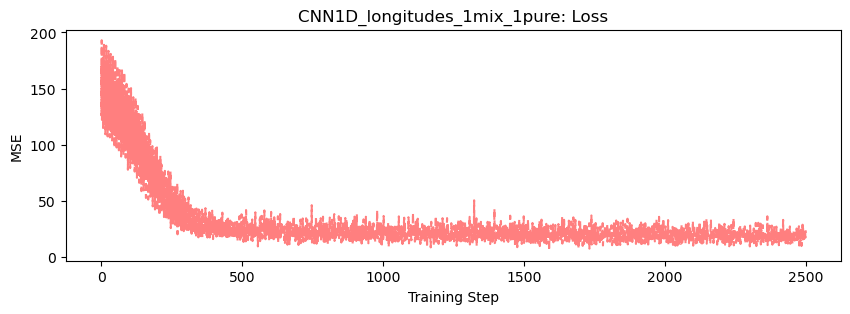

final loss: 24.08955937540989
model saved to G:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/saved_models/CNN1D_longitudes_1mix_1pure.pt
loss curve saved to G:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/loss_curves/CNN1D_longitudes_1mix_1pure.png


In [343]:
dropout = 0.5                                         # Values usually between 0.2 and 0.5
n_pure_layers = 5                                     # Values usually between 1 and 5 
n_mix_layers = 1                                      # Values usually between 1 and 5 (can be 0, but then n_pure_layers has to be 1)
n_features = 5                                        # How many imput variables do you have
n_channels = n_features * 5                           # Values usually between 2 and 5
kernel_size = 5                                       # If a 2D CNN then need to add another dimension, for example -  (5,5) 

model = CNN1D.CNN1D(                                  # for a 2D CNN this model must be changed to CNN2D.CNN2D( 
    n_pure_layers=n_pure_layers, 
    n_mix_layers=n_mix_layers, 
    n_features=n_features, 
    n_channels=n_channels,
    kernel_size=kernel_size,
    dropout=dropout
).double()

save_dir = paths.MODELS_OUTPUT                               
loss1 = train.train_model(model, 
                          'CNN1D_longitudes_1mix_1pure',    #'CNN1D_longitudes_1mix_1pure'  is the title for the figure created
                          Xt_train, 
                          Yt_train, 
                          save_dir=save_dir, 
                          conv_dim=1)                       # This is how many dimensions there are, for 2D CNN conv_dim=2

For the figure above, you are look for the plato. As the graph that contuines to go down, it means it contunies to learn and improve.  

This creates the figure and metrics for the model comparisons 

In [9]:
# Extracting all predictions in time order
train_set_pred = train.predict(model, 'CNN1D', Xt_train, Yt_train, conv_dim=1, save_dir=save_dir)   # conv_dim= number of dimensions
test_set_pred = train.predict(model, 'CNN1D', Xt_test, Yt_test, conv_dim=1, save_dir=save_dir)      # conv_dim= number of dimensions
all_preds = np.concatenate([train_set_pred, test_set_pred])

r2 = round(r2_score(test_set_pred, y_test), 3)
mse = round(mean_squared_error(test_set_pred, y_test), 3)
rmse = round(math.sqrt(mse), 3)
mae = round(mean_absolute_error(test_set_pred, y_test), 3)
mape = round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")           
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

NameError: name 'train' is not defined

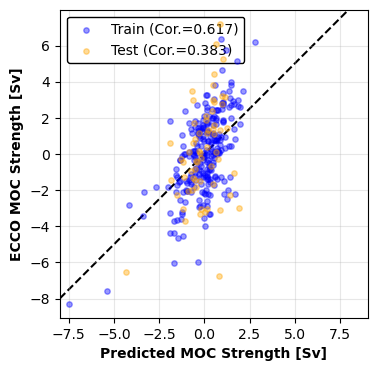

In [298]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(train_set_pred).squeeze()
y_pred_test = np.array(test_set_pred).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()